This code calculates the Hjorth parameter using the following formula:

- Hjorth = (M4 / Variance^2) - 3

- where M4 is the fourth central moment of the returns and Variance is the variance of the returns. 

- The fourth central moment, M4, measures the degree of asymmetry of the distribution of the returns. 
- A positive value of M4 indicates a more leptokurtic distribution (i.e., more peaked and heavier tails) than a normal distribution, while a negative value of M4 indicates a more platykurtic distribution (i.e., flatter and lighter tails) than a normal distribution. 

- The variance, on the other hand, measures the spread or dispersion of the returns around the mean. 

- The Hjorth parameter is a measure of the complexity of a time series, and it is based on the assumption that complex time series have more information content than simple time series. 
- The Hjorth parameter is used in finance as a measure of market efficiency, where more complex time series are considered to be more efficient than simpler time series.

In [9]:
# Importing Dependencies.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings('ignore')
##########################
import pandas as pd
import numpy as np
#########################
from scipy import stats
#########################
import cufflinks as cf
cf.go_offline()
#########################
import datetime as dt
from datetime import timedelta
##########################
import matplotlib.pyplot as plt
import pyfolio as pf
import empyrical as ep

In [10]:
from tvDatafeed import TvDatafeed, Interval
##########################################
username = ''
password = ''
##########################################
tv = TvDatafeed(username, password)
# NIFTY INDEX.
Nifty_index_data = tv.get_hist(symbol='NIFTY',
                                    exchange='NSE',
                                    interval=Interval.in_1_minute,
                                    n_bars=20000)
Nifty_index_data = df = Nifty_index_data[['symbol','open','high','low','close','volume']]
df = df.drop(columns='volume',axis=1)
#df = df.between_time('9:15', '15:00')

ERROR:tvDatafeed.main:error while signin


# Between two Date intervals 
from datetime import datetime
df = df[(df.index >= datetime(2023, 4, 11)) &  #From Date/yyyy,mm,dd/.
         (df.index <= datetime(2023, 4, 12))]   # To Date/yyyy,mm,dd/.

In [11]:
# Define function to calculate Hjorth parameter
def hjorth_param(close_prices):
    returns = np.diff(close_prices) / close_prices[:-1]
    variance = np.var(returns, ddof=1)
    m4 = np.mean(np.power(returns - np.mean(returns),4))
    hjorth = m4 / np.power(variance, 2) - 3
    return hjorth

<Axes: xlabel='datetime'>

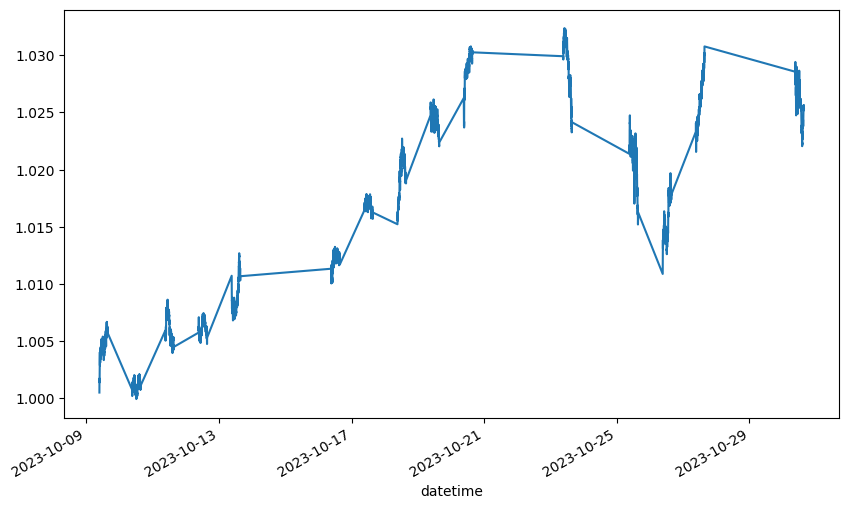

In [12]:
data = df

# Calculate Hjorth parameter for each day
data["Hjorth"] = data["close"].rolling(window=15).apply(hjorth_param, raw=True)

# Define trading strategy based on Hjorth parameter
x = 0.12
threshold_low = x #-0.12 #-0.03 #0.27
threshold_high = x #0.12 #0.03 #0.27

data["Signal"] = np.where(data["Hjorth"] < threshold_low, 1, np.where(data["Hjorth"] > threshold_high, -1, np.nan))

#data['Signal'] = data['Signal'].replace(to_replace=0,method='ffill')
#data['Signal'] = data['Signal'].where(data['Signal'].diff().fillna(0).ne(0), np.nan)

# Simulate trading based on signal
data["Returns"] = data['close'].pct_change()
data["Strategy"] = data["Returns"] * data["Signal"].shift(1)
data["Portfolio"] = np.exp(data["Strategy"].cumsum())

# Plot portfolio value over time
data["Portfolio"].plot(figsize=(10, 6))

In [13]:
# Calculate the annualised Sharpe ratio
sharpe = np.sqrt(252) * \
    df.Strategy.mean() / df.Strategy.std()
# Calculating Max Drawdown.
max_dd= ep.max_drawdown(df.Strategy)
# Calculating Stablity of Time Series of Returns.
stablity = ep.stability_of_timeseries(df.Strategy)

print(f'Start: \n{df.index[0]} \nEnd: \n{df.index[-1]}')
print("The annualised Sharpe ratio is %.2f" % sharpe)
print(f'Total Signal Counts:\n{df.Signal.value_counts()}')
print(f'Total return: {((df.Strategy.cumsum()[-1]*100)) :.4f} %') 
print(f'The Max Drawdown: {(max_dd*100):.2f} %') #times 100
print(f'Stability of Time Series: {stablity:.2f}')

Start: 
2023-10-09 09:15:00 
End: 
2023-10-30 15:29:00
The annualised Sharpe ratio is 0.24
Total Signal Counts:
Signal
 1.0    4130
-1.0    1481
Name: count, dtype: int64
Total return: 2.4977 %
The Max Drawdown: -2.09 %
Stability of Time Series: 0.71


In [14]:
data.head(50)
data.tail(50)

,symbol,open,high,low,close,Hjorth,Signal,Returns,Strategy,Portfolio
datetime,,,,,,,,,,
2023-10-09 09:15:00,NSE:NIFTY,19551.40,19551.40,19503.20,19507.60,NaN,NaN,NaN,NaN,NaN
2023-10-09 09:16:00,NSE:NIFTY,19509.65,19513.95,19505.70,19512.15,NaN,NaN,0.000233,NaN,NaN
2023-10-09 09:17:00,NSE:NIFTY,19510.55,19517.85,19504.75,19506.60,NaN,NaN,-0.000284,NaN,NaN
2023-10-09 09:18:00,NSE:NIFTY,19506.85,19513.50,19505.70,19509.85,NaN,NaN,0.000167,NaN,NaN
2023-10-09 09:19:00,NSE:NIFTY,19510.10,19513.35,19505.15,19505.25,NaN,NaN,-0.000236,NaN,NaN
2023-10-09 09:20:00,NSE:NIFTY,19504.50,19504.50,19494.95,19499.85,NaN,NaN,-0.000277,NaN,NaN
2023-10-09 09:21:00,NSE:NIFTY,19500.70,19501.25,19489.50,19491.30,NaN,NaN,-0.000438,NaN,NaN
2023-10-09 09:22:00,NSE:NIFTY,19492.60,19492.60,19480.50,19486.55,NaN,NaN,-0.000244,NaN,NaN
2023-10-09 09:23:00,NSE:NIFTY,19487.05,19500.75,19487.05,19500.15,NaN,NaN,0.000698,NaN,NaN


,symbol,open,high,low,close,Hjorth,Signal,Returns,Strategy,Portfolio
datetime,,,,,,,,,,
2023-10-30 14:40:00,NSE:NIFTY,19122.05,19122.90,19120.90,19122.25,-1.299465,1.0,0.000050,0.000050,1.023696
2023-10-30 14:41:00,NSE:NIFTY,19121.60,19123.85,19121.05,19121.05,-1.542297,1.0,-0.000063,-0.000063,1.023632
2023-10-30 14:42:00,NSE:NIFTY,19120.45,19121.30,19118.85,19121.10,-1.394593,1.0,0.000003,0.000003,1.023634
2023-10-30 14:43:00,NSE:NIFTY,19120.15,19124.10,19119.90,19124.10,-1.439876,1.0,0.000157,0.000157,1.023795
2023-10-30 14:44:00,NSE:NIFTY,19123.60,19128.90,19123.60,19127.25,-1.433785,1.0,0.000165,0.000165,1.023963
2023-10-30 14:45:00,NSE:NIFTY,19126.75,19129.25,19126.05,19129.25,-1.110329,1.0,0.000105,0.000105,1.024071
2023-10-30 14:46:00,NSE:NIFTY,19127.80,19130.55,19123.40,19124.45,-0.962702,1.0,-0.000251,-0.000251,1.023814
2023-10-30 14:47:00,NSE:NIFTY,19124.00,19126.20,19122.75,19124.50,-0.881516,1.0,0.000003,0.000003,1.023816
2023-10-30 14:48:00,NSE:NIFTY,19123.75,19126.35,19122.85,19126.35,-0.762059,1.0,0.000097,0.000097,1.023915


In [15]:
j = df.Signal  # forward-fill missing values in df.position
e = df.close

result = []
for i in range(len(j)):
    if i == len(j)-1 or pd.isna(j[i]) or pd.isna(j[i+1]):
        result.append(0)  # if there's a missing value or last row, append 0
    elif j[i] == -1:
        result.append(e[i] - e[i+1])
    elif j[i] == 1:
        result.append(e[i+1] - e[i])
    else:
        result.append(0)

total = sum(result)
print(f'Gains in Points: {total:.2f}')

Gains in Points: 489.10


Start date,2023-10-09
End date,2023-10-30
Total months,267
,Backtest
Annual return,0.111%
Cumulative returns,2.504%
Annual volatility,0.473%
Sharpe ratio,0.24
Calmar ratio,0.05
Stability,0.71
Max drawdown,-2.088%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,2.09,2023-10-23,2023-10-26,NaT,NaN
1,0.67,2023-10-09,2023-10-10,2023-10-11,2
2,0.46,2023-10-11,2023-10-11,2023-10-13,2
3,0.40,2023-10-19,2023-10-19,2023-10-20,1
4,0.39,2023-10-13,2023-10-13,2023-10-13,1


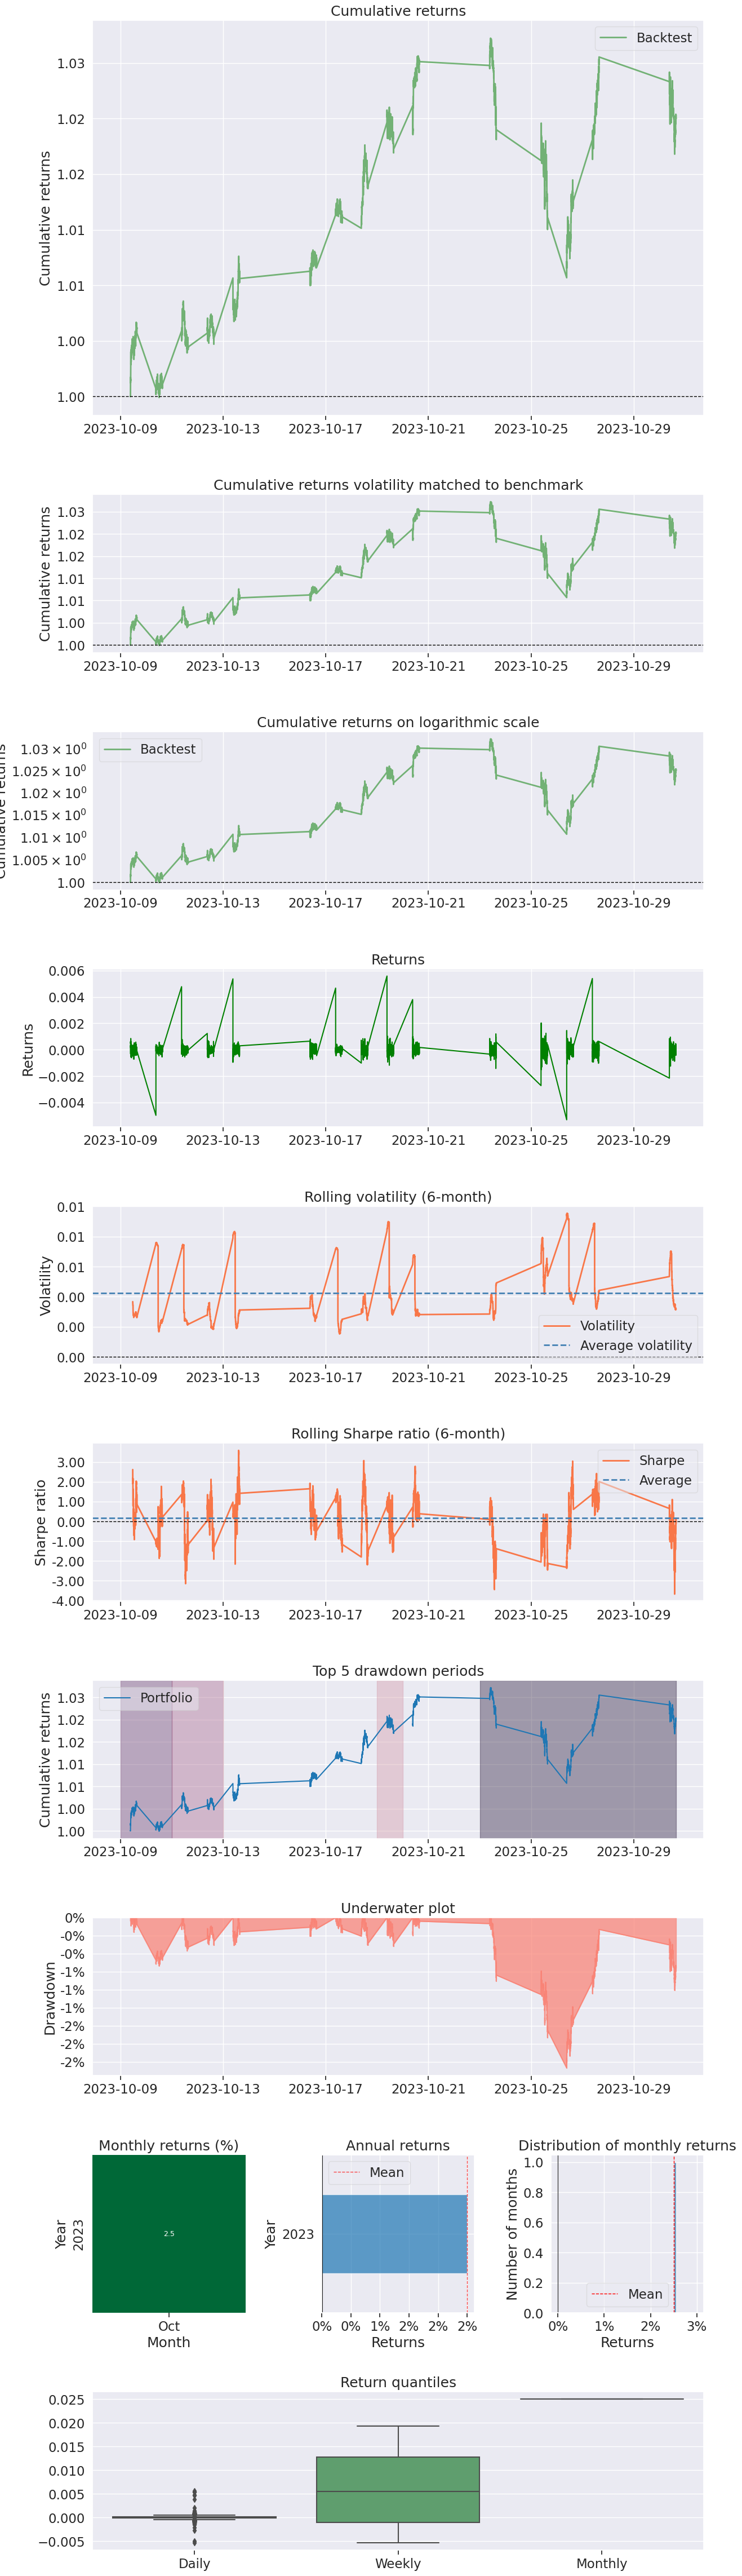

In [16]:
pf.create_full_tear_sheet(df['Strategy'])